In [1]:
import glob, os, sys, tifffile
from tqdm import tqdm

import pandas as pd
import numpy as np
import librosa

import matplotlib.pyplot as plt
from IPython import display

In [2]:
params = {
    'block_second': 1.5,
    'resampling_rate': 32000,
    'n_fft': 1024,
    'hop_length': 750,
    'win_length': 1024,
    'lower_hertz': 50,
    'upper_hertz': 14000,
    'mel_bins': 64
}

In [3]:
def load_wav(filename, resampling_rate=params['resampling_rate']):
    wav_data, sample_rate = librosa.load(filename, mono=False, sr=resampling_rate)
    return wav_data, sample_rate

def save_tiff(filename, data):
    tifffile.imwrite(filename, data)

def spectrogram(data, n_fft=2048, hop_length=None, win_length=None,
        window='hann', center=True, pad_mode='reflect', power=2.0):
    stft_data = librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
        window=window, center=center, pad_mode=pad_mode)
    spectrogram = np.abs(stft_data)
    return spectrogram

def logmel_spectrogram(data, sr=22050, n_fft=2048, n_mels=64, fmin=0.0, fmax=None, 
        is_log=True, ref=1.0, amin=1e-10, top_db=None):
    melW = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels,
            fmin=fmin, fmax=fmax).T
    mel_spectrogram = np.matmul(data.T, melW)

    def power_to_db(mel_spectrogram):
        ref_value = ref
        log_spec = 10.0 * np.log10(np.clip(mel_spectrogram, a_min=amin, a_max=np.inf))
        log_spec -= 10.0 * np.log10(np.maximum(amin, ref_value))

        if top_db is not None:
            if top_db < 0:
                raise librosa.util.exceptions.ParameterError('top_db must be non-negative')
            log_spec = np.clip(log_spec, a_min=log_spec.max().item() - top_db, a_max=np.inf)
        return log_spec

    if is_log:
        logmel = power_to_db(mel_spectrogram)
    else:
        logmel = mel_spectrogram
    return logmel

In [4]:
def convert_to_logmel_data(wav_file):
    wav_data, sr = load_wav(wav_file)
    block_point = int(sr * params['block_second'])
    smaple_point = wav_data.shape[0]
    if smaple_point <= block_point:
        wav_data = np.pad(wav_data, (0, block_point - smaple_point))
    else:
        wav_data = wav_data[:block_point]
    
    # plt.figure(figsize=(10, 4))
    # librosa.display.waveshow(wav_data, sr=sr)
    # plt.show()

    melspec = spectrogram(data=wav_data,
                        n_fft=params['n_fft'], 
                        hop_length=params['hop_length'], 
                        win_length=params['win_length'],
                        window='hann',
                        center=True,
                        pad_mode='reflect')
    print(melspec.shape)
    logmel = logmel_spectrogram(data=melspec,
                                sr=params['resampling_rate'],
                                n_fft=params['n_fft'], 
                                n_mels=params['mel_bins'],
                                fmin=params['lower_hertz'],
                                fmax=params['upper_hertz'])
    print(logmel.shape)

    save_tiff('./temp.tiff', logmel)

    plt.figure(figsize=(10, 4))
    plt.imshow(np.flipud(np.transpose(logmel)), 
        cmap=plt.cm.jet, 
        aspect='auto',
        extent=[0, logmel.shape[0], 0, logmel.shape[1]])
    plt.show()
    
    return wav_data, logmel

(513, 65)
(65, 64)


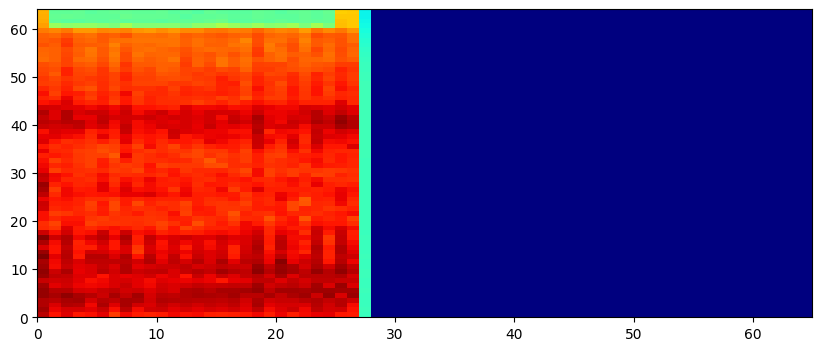

In [5]:
# with bark
wav_file = '/media/ubuntu/HD_new/download/audioset/audios/eval_segments/Y1MP3sQTk8wo.wav'

# without bark
# wav_file = '/home/whq/dataset_link1/Audioset-Seg/data/Wood/lZEigCNUq-g_0.wav'

wav_data, logmel = convert_to_logmel_data(wav_file)
display.Audio(wav_data, rate=params['resampling_rate'])

In [13]:
import tensorflow as tf
import numpy as np

def freq_mask(input, drop_width, stripes_num):
    processed_data = []
    for data in input:
        freq_max = data.shape[0]
        t = np.random.randint(0, drop_width)  # 使用 np.random.randint 生成随机整数
        t0 = np.random.randint(0, freq_max - t)  # 使用 np.random.randint 生成随机整数
        indices = np.arange(freq_max).reshape(-1, 1)
        condition = np.logical_and(
            np.greater_equal(indices, t0), np.less(indices, t0 + t)
        )
        strpies_index = np.array([i % stripes_num == 0 for i in range(1, 1 + freq_max)])
        strpies_index = strpies_index.reshape(-1, 1)
        condition = np.logical_and(condition, strpies_index)
        data = np.where(condition, 0, data)  # 使用 np.where 进行条件替换
        processed_data.append(data)
    return processed_data

def time_mask(input, drop_width, stripes_num):
    processed_data = []
    for data in input:
        time_max = data.shape[0]
        t = np.random.randint(0, drop_width)  # 使用 np.random.randint 生成随机整数
        t0 = np.random.randint(0, time_max - t)  # 使用 np.random.randint 生成随机整数
        indices = np.arange(time_max).reshape(-1, 1)
        condition = np.logical_and(
            np.greater_equal(indices, t0), np.less(indices, t0 + t)
        )
        strpies_index = np.array([i % stripes_num == 0 for i in range(1, 1 + time_max)])
        strpies_index = strpies_index.reshape(-1, 1)
        condition = np.logical_and(condition, strpies_index)
        data = np.where(condition, 0, data)  # 使用 np.where 进行条件替换
        processed_data.append(data)
    return processed_data

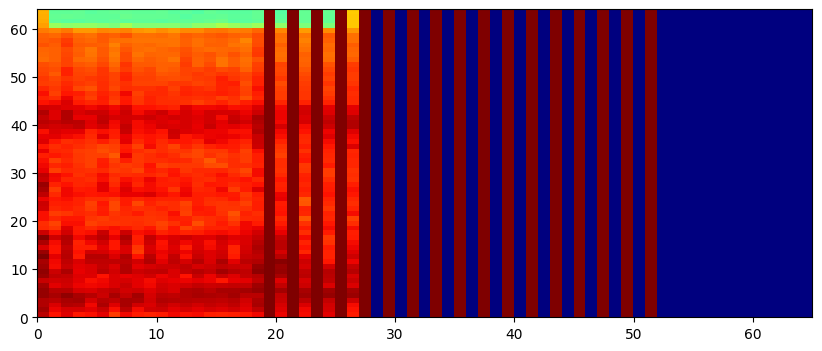

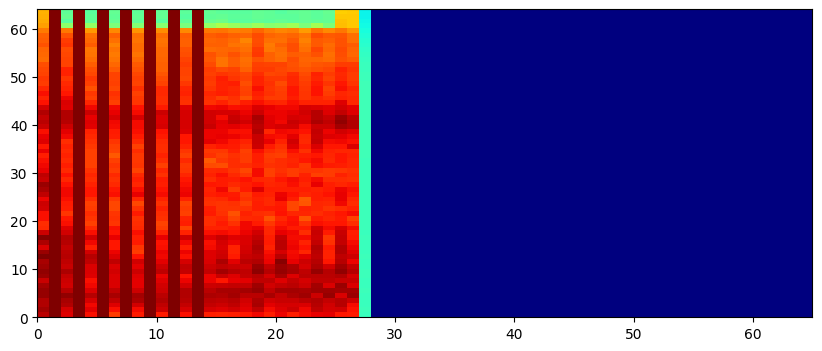

In [17]:
logmel_aug = time_mask(np.expand_dims(logmel, 0), drop_width=64, stripes_num=2)
logmel_aug = logmel_aug[0]

plt.figure(figsize=(10, 4))
plt.imshow(np.flipud(np.transpose(logmel_aug)), 
    cmap=plt.cm.jet, 
    aspect='auto',
    extent=[0, logmel_aug.shape[0], 0, logmel_aug.shape[1]])
plt.show()

logmel_aug = freq_mask(np.expand_dims(logmel, 0), drop_width=16, stripes_num=2)
logmel_aug = logmel_aug[0]

plt.figure(figsize=(10, 4))
plt.imshow(np.flipud(np.transpose(logmel_aug)), 
    cmap=plt.cm.jet, 
    aspect='auto',
    extent=[0, logmel_aug.shape[0], 0, logmel_aug.shape[1]])
plt.show()